In [1]:
# pip install yfinance transformers torch

In [2]:
# import yfinance as yf
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

In [3]:
import torch
from torch import nn
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# 1. Read Data

In [4]:
df_cleaned = pd.read_csv('stock_prices_cleaned.csv')
# Convert 'Date' to datetime format 
df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])
print(f"shape: {df_cleaned.shape}")
df_cleaned.head()

shape: (52783, 14)


,Date,Ticker,Volume,High,Low,Open,Close,target_next_close,daily_return,moving_avg_5,moving_avg_10,volatility_5,target_next_close_lag1,target_next_close_lag2
0,2000-01-04,BA,3592100.0,26.545424,25.657887,25.940285,25.899942,56.521271,-0.001555,14.616987,17.393754,15.358752,25.899942,4.096875
1,2000-01-04,IBM,8606279.0,57.750680,55.922328,57.498493,56.521271,10.991455,-0.016996,18.762780,22.961666,23.265865,56.521271,25.899942
2,2000-01-04,MGM,408000.0,11.196903,10.859382,11.094179,10.991455,34.583225,-0.009259,19.656138,23.613937,22.758698,10.991455,56.521271
3,2000-01-04,MSFT,54119000.0,35.965019,34.468076,34.871099,34.583225,6.142899,-0.008255,26.418554,24.478230,20.672186,34.583225,10.991455
4,2000-01-04,T,9497846.0,6.628778,6.038782,6.533338,6.142899,0.782433,-0.059761,26.827759,19.241797,20.133087,6.142899,34.583225


# Data pre-processing

In [5]:
# Feature scaling
features = ['Volume', 'High', 'Low', 'Open', 'Close']
scaler = MinMaxScaler()
df_cleaned[features] = scaler.fit_transform(df_cleaned[features])
df_cleaned.head()

,Date,Ticker,Volume,High,Low,Open,Close,target_next_close,daily_return,moving_avg_5,moving_avg_10,volatility_5,target_next_close_lag1,target_next_close_lag2
0,2000-01-04,BA,0.000464,0.053952,0.055172,0.054119,0.053585,56.521271,-0.001555,14.616987,17.393754,15.358752,25.899942,4.096875
1,2000-01-04,IBM,0.001140,0.117852,0.120739,0.120459,0.117424,10.991455,-0.016996,18.762780,22.961666,23.265865,56.521271,25.899942
2,2000-01-04,MGM,0.000035,0.022522,0.023112,0.022911,0.022503,34.583225,-0.009259,19.656138,23.613937,22.758698,10.991455,56.521271
3,2000-01-04,MSFT,0.007272,0.073241,0.074259,0.072893,0.071688,6.142899,-0.008255,26.418554,24.478230,20.672186,34.583225,10.991455
4,2000-01-04,T,0.001260,0.013168,0.012668,0.013323,0.012395,0.782433,-0.059761,26.827759,19.241797,20.133087,6.142899,34.583225


In [6]:
# Create sequences
window_size = 20

def create_sequences(data, target_col):
    sequences = []
    targets = []
    indices = []
    for i in range(len(data) - window_size):
        seq = data.iloc[i:i+window_size][features].values
        label = data.iloc[i+window_size][target_col]
        sequences.append(seq)
        targets.append(label)
        indices.append(data.index[i + window_size])
    return np.array(sequences), np.array(targets), indices

In [7]:
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def create_train_test(X_train, y_train, X_test, y_test):
    train_loader = DataLoader(StockDataset(X_train, y_train), batch_size=32, shuffle=False)
    test_loader = DataLoader(StockDataset(X_test, y_test), batch_size=32, shuffle=False)
    return train_loader, test_loader

# LSTM Model

In [8]:
# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=3, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out.squeeze()

## Fine tuning the model per ticker

In [9]:
# Fine-tune per ticker
results = []
for ticker in df_cleaned['Ticker'].unique():
    group = df_cleaned[df_cleaned['Ticker'] == ticker].reset_index(drop=True)

    # Target scaler (fit only on train portion)
    split_point = int(0.8 * len(group))
    scaler_y = MinMaxScaler()
    scaler_y.fit(group.loc[:split_point][['target_next_close']])
    group['target_next_close_scaled'] = scaler_y.transform(group[['target_next_close']])

    # Sequences
    X, y, idx = create_sequences(group, 'target_next_close_scaled')
    split = int(0.9 * len(X))
    X_train, y_train = X[:split], y[:split]
    X_test, y_test = X[split:], y[split:]
    test_idx = idx[split:]

    # Dataset class
    train_loader, test_loader = create_train_test(X_train, y_train, X_test, y_test)

    # Model
    model = LSTMModel(input_size=len(features))
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train
    train_epoch = 50
    for epoch in range(train_epoch):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = loss_fn(output, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"{ticker} - Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")

    # Predict
    model.eval()
    y_true_scaled, y_pred_scaled = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            preds = model(X_batch)
            y_true_scaled.extend(y_batch.numpy())
            # y_pred_scaled.extend(preds.numpy())
            y_pred_scaled.extend(preds.view(-1).numpy())

    # Inverse transform
    y_true = scaler_y.inverse_transform(np.array(y_true_scaled).reshape(-1, 1)).flatten()
    y_pred = scaler_y.inverse_transform(np.array(y_pred_scaled).reshape(-1, 1)).flatten()

    # Map to df
    results.append(pd.DataFrame({
        'Date': group.loc[test_idx]['Date'].values,
        'Ticker': ticker,
        'target_next_close': group.loc[test_idx]['target_next_close'].values,
        'pred_target_next_close': y_pred
    }))

    print(f"results: {results}")

MinMaxScaler()

LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

BA - Epoch 1, Loss: 0.0398


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

BA - Epoch 2, Loss: 0.0313


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

BA - Epoch 3, Loss: 0.0573


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

BA - Epoch 4, Loss: 0.0850


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

BA - Epoch 5, Loss: 0.0508


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

BA - Epoch 6, Loss: 0.1396


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

BA - Epoch 7, Loss: 0.1663


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

BA - Epoch 8, Loss: 0.1808


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

BA - Epoch 9, Loss: 0.2079


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

BA - Epoch 10, Loss: 0.2228


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

BA - Epoch 11, Loss: 0.2294


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

BA - Epoch 12, Loss: 0.2327


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

BA - Epoch 13, Loss: 0.2349


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

BA - Epoch 14, Loss: 0.2365


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

BA - Epoch 15, Loss: 0.2376


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

BA - Epoch 16, Loss: 0.2385


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

BA - Epoch 17, Loss: 0.2392


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

BA - Epoch 18, Loss: 0.2397


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

BA - Epoch 19, Loss: 0.2352


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

BA - Epoch 20, Loss: 0.2421


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

BA - Epoch 21, Loss: 0.2408


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

BA - Epoch 22, Loss: 0.2410


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

BA - Epoch 23, Loss: 0.2412


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

BA - Epoch 24, Loss: 0.2414


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

BA - Epoch 25, Loss: 0.2415


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

BA - Epoch 26, Loss: 0.2416


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

BA - Epoch 27, Loss: 0.2417


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

BA - Epoch 28, Loss: 0.2418


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

BA - Epoch 29, Loss: 0.0955


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

BA - Epoch 30, Loss: 0.0628


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

BA - Epoch 31, Loss: 0.1454


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

BA - Epoch 32, Loss: 0.1829


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

BA - Epoch 33, Loss: 0.1917


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

BA - Epoch 34, Loss: 0.2266


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

BA - Epoch 35, Loss: 0.2465


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

BA - Epoch 36, Loss: 0.2470


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

BA - Epoch 37, Loss: 0.2494


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

BA - Epoch 38, Loss: 0.2487


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

BA - Epoch 39, Loss: 0.2489


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

BA - Epoch 40, Loss: 0.2491


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

BA - Epoch 41, Loss: 0.2492


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

BA - Epoch 42, Loss: 0.2493


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

BA - Epoch 43, Loss: 0.2494


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

BA - Epoch 44, Loss: 0.2494


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

BA - Epoch 45, Loss: 0.2494


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

BA - Epoch 46, Loss: 0.2495


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

BA - Epoch 47, Loss: 0.2495


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

BA - Epoch 48, Loss: 0.2495


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

BA - Epoch 49, Loss: 0.2495


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

BA - Epoch 50, Loss: 0.2496


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

results: [          Date Ticker  target_next_close  pred_target_next_close
0   2022-07-05     BA         113.350121               48.195244
1   2022-07-06     BA         114.670364               48.195244
2   2022-07-07     BA         118.743568               48.195244
3   2022-07-08     BA         119.602005               48.195244
4   2022-07-11     BA         115.973198               48.195244
..         ...    ...                ...                     ...
622 2024-12-23     BA         195.766968               48.195244
623 2024-12-24     BA         197.345184               48.195244
624 2024-12-26     BA         196.875717               48.195244
625 2024-12-27     BA         193.819183               48.195244
626 2024-12-30     BA         192.470734               48.195244

[627 rows x 4 columns]]


MinMaxScaler()

LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

IBM - Epoch 1, Loss: 0.0090


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

IBM - Epoch 2, Loss: 0.0131


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

IBM - Epoch 3, Loss: 0.0331


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

IBM - Epoch 4, Loss: 0.0368


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

IBM - Epoch 5, Loss: 0.0344


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

IBM - Epoch 6, Loss: 0.0337


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

IBM - Epoch 7, Loss: 0.0333


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

IBM - Epoch 8, Loss: 0.0329


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

IBM - Epoch 9, Loss: 0.0326


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

IBM - Epoch 10, Loss: 0.0324


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

IBM - Epoch 11, Loss: 0.0322


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

IBM - Epoch 12, Loss: 0.0321


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

IBM - Epoch 13, Loss: 0.0320


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

IBM - Epoch 14, Loss: 0.0317


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

IBM - Epoch 15, Loss: 0.0316


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

IBM - Epoch 16, Loss: 0.0315


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

IBM - Epoch 17, Loss: 0.0315


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

IBM - Epoch 18, Loss: 0.0314


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

IBM - Epoch 19, Loss: 0.0313


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

IBM - Epoch 20, Loss: 0.0311


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

IBM - Epoch 21, Loss: 0.0310


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

IBM - Epoch 22, Loss: 0.0309


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

IBM - Epoch 23, Loss: 0.0309


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

IBM - Epoch 24, Loss: 0.0307


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

IBM - Epoch 25, Loss: 0.0308


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

IBM - Epoch 26, Loss: 0.0307


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

IBM - Epoch 27, Loss: 0.0306


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

IBM - Epoch 28, Loss: 0.0305


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

IBM - Epoch 29, Loss: 0.0304


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

IBM - Epoch 30, Loss: 0.0302


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

IBM - Epoch 31, Loss: 0.0302


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

IBM - Epoch 32, Loss: 0.0302


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

IBM - Epoch 33, Loss: 0.0301


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

IBM - Epoch 34, Loss: 0.0301


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

IBM - Epoch 35, Loss: 0.0301


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

IBM - Epoch 36, Loss: 0.0299


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

IBM - Epoch 37, Loss: 0.0300


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

IBM - Epoch 38, Loss: 0.0299


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

IBM - Epoch 39, Loss: 0.0298


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

IBM - Epoch 40, Loss: 0.0298


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

IBM - Epoch 41, Loss: 0.0298


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

IBM - Epoch 42, Loss: 0.0297


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

IBM - Epoch 43, Loss: 0.0297


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

IBM - Epoch 44, Loss: 0.0297


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

IBM - Epoch 45, Loss: 0.0297


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

IBM - Epoch 46, Loss: 0.0297


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

IBM - Epoch 47, Loss: 0.0296


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

IBM - Epoch 48, Loss: 0.0297


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

IBM - Epoch 49, Loss: 0.0296


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

IBM - Epoch 50, Loss: 0.0296


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

results: [          Date Ticker  target_next_close  pred_target_next_close
0   2022-07-05     BA         113.350121               48.195244
1   2022-07-06     BA         114.670364               48.195244
2   2022-07-07     BA         118.743568               48.195244
3   2022-07-08     BA         119.602005               48.195244
4   2022-07-11     BA         115.973198               48.195244
..         ...    ...                ...                     ...
622 2024-12-23     BA         195.766968               48.195244
623 2024-12-24     BA         197.345184               48.195244
624 2024-12-26     BA         196.875717               48.195244
625 2024-12-27     BA         193.819183               48.195244
626 2024-12-30     BA         192.470734               48.195244

[627 rows x 4 columns],           Date Ticker  target_next_close  pred_target_next_close
0   2022-07-05    IBM          30.354788               25.385775
1   2022-07-06    IBM          29.534927               

MinMaxScaler()

LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MGM - Epoch 1, Loss: 0.0067


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MGM - Epoch 2, Loss: 0.0382


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MGM - Epoch 3, Loss: 0.0467


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MGM - Epoch 4, Loss: 0.1365


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MGM - Epoch 5, Loss: 0.0762


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MGM - Epoch 6, Loss: 0.2429


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MGM - Epoch 7, Loss: 0.2532


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MGM - Epoch 8, Loss: 0.2891


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MGM - Epoch 9, Loss: 0.2942


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MGM - Epoch 10, Loss: 0.2903


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MGM - Epoch 11, Loss: 0.2902


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MGM - Epoch 12, Loss: 0.2902


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MGM - Epoch 13, Loss: 0.2888


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MGM - Epoch 14, Loss: 0.2899


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MGM - Epoch 15, Loss: 0.2911


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MGM - Epoch 16, Loss: 0.2882


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MGM - Epoch 17, Loss: 0.2900


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MGM - Epoch 18, Loss: 0.2915


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MGM - Epoch 19, Loss: 0.2933


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MGM - Epoch 20, Loss: 0.2929


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MGM - Epoch 21, Loss: 0.2922


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MGM - Epoch 22, Loss: 0.2924


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MGM - Epoch 23, Loss: 0.2941


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MGM - Epoch 24, Loss: 0.2892


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MGM - Epoch 25, Loss: 0.2924


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MGM - Epoch 26, Loss: 0.2923


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MGM - Epoch 27, Loss: 0.2924


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MGM - Epoch 28, Loss: 0.2924


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MGM - Epoch 29, Loss: 0.2928


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MGM - Epoch 30, Loss: 0.3063


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MGM - Epoch 31, Loss: 0.2950


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MGM - Epoch 32, Loss: 0.2954


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MGM - Epoch 33, Loss: 0.2952


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MGM - Epoch 34, Loss: 0.2953


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MGM - Epoch 35, Loss: 0.2953


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MGM - Epoch 36, Loss: 0.2953


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MGM - Epoch 37, Loss: 0.2953


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MGM - Epoch 38, Loss: 0.2954


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MGM - Epoch 39, Loss: 0.2952


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MGM - Epoch 40, Loss: 0.2953


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MGM - Epoch 41, Loss: 0.2953


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MGM - Epoch 42, Loss: 0.2953


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MGM - Epoch 43, Loss: 0.2953


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MGM - Epoch 44, Loss: 0.2953


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MGM - Epoch 45, Loss: 0.2953


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MGM - Epoch 46, Loss: 0.2952


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MGM - Epoch 47, Loss: 0.2953


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MGM - Epoch 48, Loss: 0.2953


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MGM - Epoch 49, Loss: 0.2953


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MGM - Epoch 50, Loss: 0.2953


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

results: [          Date Ticker  target_next_close  pred_target_next_close
0   2022-07-05     BA         113.350121               48.195244
1   2022-07-06     BA         114.670364               48.195244
2   2022-07-07     BA         118.743568               48.195244
3   2022-07-08     BA         119.602005               48.195244
4   2022-07-11     BA         115.973198               48.195244
..         ...    ...                ...                     ...
622 2024-12-23     BA         195.766968               48.195244
623 2024-12-24     BA         197.345184               48.195244
624 2024-12-26     BA         196.875717               48.195244
625 2024-12-27     BA         193.819183               48.195244
626 2024-12-30     BA         192.470734               48.195244

[627 rows x 4 columns],           Date Ticker  target_next_close  pred_target_next_close
0   2022-07-05    IBM          30.354788               25.385775
1   2022-07-06    IBM          29.534927               

MinMaxScaler()

LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 1, Loss: 0.0084


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 2, Loss: 0.0185


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 3, Loss: 0.0211


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 4, Loss: 0.0272


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 5, Loss: 0.0368


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 6, Loss: 0.0490


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 7, Loss: 0.0585


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 8, Loss: 0.0687


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 9, Loss: 0.0640


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 10, Loss: 0.0412


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 11, Loss: 0.1026


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 12, Loss: 0.0834


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 13, Loss: 0.0828


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 14, Loss: 0.0822


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 15, Loss: 0.0818


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 16, Loss: 0.0816


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 17, Loss: 0.0814


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 18, Loss: 0.0813


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 19, Loss: 0.0811


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 20, Loss: 0.0811


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 21, Loss: 0.0810


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 22, Loss: 0.0810


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 23, Loss: 0.0809


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 24, Loss: 0.0809


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 25, Loss: 0.0809


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 26, Loss: 0.0808


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 27, Loss: 0.0808


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 28, Loss: 0.0808


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 29, Loss: 0.0808


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 30, Loss: 0.0808


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 31, Loss: 0.0808


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 32, Loss: 0.0808


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 33, Loss: 0.0808


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 34, Loss: 0.0808


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 35, Loss: 0.0808


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 36, Loss: 0.0808


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 37, Loss: 0.0808


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 38, Loss: 0.0808


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 39, Loss: 0.0808


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 40, Loss: 0.0807


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 41, Loss: 0.0807


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 42, Loss: 0.0807


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 43, Loss: 0.0807


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 44, Loss: 0.0807


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 45, Loss: 0.0807


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 46, Loss: 0.0807


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 47, Loss: 0.0807


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 48, Loss: 0.0807


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 49, Loss: 0.0807


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 50, Loss: 0.0807


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

results: [          Date Ticker  target_next_close  pred_target_next_close
0   2022-07-05     BA         113.350121               48.195244
1   2022-07-06     BA         114.670364               48.195244
2   2022-07-07     BA         118.743568               48.195244
3   2022-07-08     BA         119.602005               48.195244
4   2022-07-11     BA         115.973198               48.195244
..         ...    ...                ...                     ...
622 2024-12-23     BA         195.766968               48.195244
623 2024-12-24     BA         197.345184               48.195244
624 2024-12-26     BA         196.875717               48.195244
625 2024-12-27     BA         193.819183               48.195244
626 2024-12-30     BA         192.470734               48.195244

[627 rows x 4 columns],           Date Ticker  target_next_close  pred_target_next_close
0   2022-07-05    IBM          30.354788               25.385775
1   2022-07-06    IBM          29.534927               

MinMaxScaler()

LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

T - Epoch 1, Loss: 1.3379


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

T - Epoch 2, Loss: 12.8369


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

T - Epoch 3, Loss: 7.2842


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

T - Epoch 4, Loss: 7.2059


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

T - Epoch 5, Loss: 7.1869


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

T - Epoch 6, Loss: 7.1922


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

T - Epoch 7, Loss: 7.2057


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

T - Epoch 8, Loss: 7.1727


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

T - Epoch 9, Loss: 7.2085


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

T - Epoch 10, Loss: 7.2412


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

T - Epoch 11, Loss: 7.1881


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

T - Epoch 12, Loss: 7.1713


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

T - Epoch 13, Loss: 7.1661


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

T - Epoch 14, Loss: 7.1455


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

T - Epoch 15, Loss: 7.1174


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

T - Epoch 16, Loss: 7.1429


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

T - Epoch 17, Loss: 7.1201


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

T - Epoch 18, Loss: 7.1542


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

T - Epoch 19, Loss: 7.1169


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

T - Epoch 20, Loss: 7.1266


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

T - Epoch 21, Loss: 7.1196


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

T - Epoch 22, Loss: 7.1156


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

T - Epoch 23, Loss: 7.1407


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

T - Epoch 24, Loss: 7.1374


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

T - Epoch 25, Loss: 7.1098


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

T - Epoch 26, Loss: 7.1211


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

T - Epoch 27, Loss: 7.1040


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

T - Epoch 28, Loss: 7.1046


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

T - Epoch 29, Loss: 7.1044


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

T - Epoch 30, Loss: 7.1049


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

T - Epoch 31, Loss: 7.1046


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

T - Epoch 32, Loss: 7.1051


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

T - Epoch 33, Loss: 7.1039


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

T - Epoch 34, Loss: 7.1047


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

T - Epoch 35, Loss: 7.1047


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

T - Epoch 36, Loss: 7.1045


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

T - Epoch 37, Loss: 7.1274


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

T - Epoch 38, Loss: 7.1013


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

T - Epoch 39, Loss: 7.1019


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

T - Epoch 40, Loss: 7.1045


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

T - Epoch 41, Loss: 7.1066


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

T - Epoch 42, Loss: 7.0914


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

T - Epoch 43, Loss: 7.1023


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

T - Epoch 44, Loss: 7.1023


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

T - Epoch 45, Loss: 7.1022


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

T - Epoch 46, Loss: 7.1023


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

T - Epoch 47, Loss: 7.1022


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

T - Epoch 48, Loss: 7.1023


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

T - Epoch 49, Loss: 7.1022


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

T - Epoch 50, Loss: 7.1022


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

results: [          Date Ticker  target_next_close  pred_target_next_close
0   2022-07-05     BA         113.350121               48.195244
1   2022-07-06     BA         114.670364               48.195244
2   2022-07-07     BA         118.743568               48.195244
3   2022-07-08     BA         119.602005               48.195244
4   2022-07-11     BA         115.973198               48.195244
..         ...    ...                ...                     ...
622 2024-12-23     BA         195.766968               48.195244
623 2024-12-24     BA         197.345184               48.195244
624 2024-12-26     BA         196.875717               48.195244
625 2024-12-27     BA         193.819183               48.195244
626 2024-12-30     BA         192.470734               48.195244

[627 rows x 4 columns],           Date Ticker  target_next_close  pred_target_next_close
0   2022-07-05    IBM          30.354788               25.385775
1   2022-07-06    IBM          29.534927               

MinMaxScaler()

LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 1, Loss: 0.0126


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 2, Loss: 0.0539


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 3, Loss: 0.0555


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 4, Loss: 0.0498


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 5, Loss: 0.0693


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 6, Loss: 0.0551


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 7, Loss: 0.1741


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 8, Loss: 0.2376


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 9, Loss: 0.2538


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 10, Loss: 0.2533


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 11, Loss: 0.2548


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 12, Loss: 0.2560


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 13, Loss: 0.2527


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 14, Loss: 0.2641


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 15, Loss: 0.2545


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 16, Loss: 0.2571


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 17, Loss: 0.2644


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 18, Loss: 0.2583


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 19, Loss: 0.2576


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 20, Loss: 0.2579


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 21, Loss: 0.2579


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 22, Loss: 0.2578


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 23, Loss: 0.2580


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 24, Loss: 0.2574


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 25, Loss: 0.2578


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 26, Loss: 0.2577


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 27, Loss: 0.2577


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 28, Loss: 0.2578


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 29, Loss: 0.2574


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 30, Loss: 0.2577


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 31, Loss: 0.2577


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 32, Loss: 0.2579


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 33, Loss: 0.2572


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 34, Loss: 0.2576


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 35, Loss: 0.2576


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 36, Loss: 0.2577


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 37, Loss: 0.2579


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 38, Loss: 0.2571


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 39, Loss: 0.2576


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 40, Loss: 0.2576


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 41, Loss: 0.2576


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 42, Loss: 0.2579


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 43, Loss: 0.2572


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 44, Loss: 0.2576


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 45, Loss: 0.2577


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 46, Loss: 0.2576


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 47, Loss: 0.2577


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 48, Loss: 0.2576


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 49, Loss: 0.2575


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 50, Loss: 0.2577


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

results: [          Date Ticker  target_next_close  pred_target_next_close
0   2022-07-05     BA         113.350121               48.195244
1   2022-07-06     BA         114.670364               48.195244
2   2022-07-07     BA         118.743568               48.195244
3   2022-07-08     BA         119.602005               48.195244
4   2022-07-11     BA         115.973198               48.195244
..         ...    ...                ...                     ...
622 2024-12-23     BA         195.766968               48.195244
623 2024-12-24     BA         197.345184               48.195244
624 2024-12-26     BA         196.875717               48.195244
625 2024-12-27     BA         193.819183               48.195244
626 2024-12-30     BA         192.470734               48.195244

[627 rows x 4 columns],           Date Ticker  target_next_close  pred_target_next_close
0   2022-07-05    IBM          30.354788               25.385775
1   2022-07-06    IBM          29.534927               

MinMaxScaler()

LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 1, Loss: 0.0069


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 2, Loss: 0.0201


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 3, Loss: 0.0208


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 4, Loss: 0.0239


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 5, Loss: 0.0371


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 6, Loss: 0.0526


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 7, Loss: 0.0718


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 8, Loss: 0.0618


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 9, Loss: 0.0607


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 10, Loss: 0.0604


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 11, Loss: 0.0602


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 12, Loss: 0.0601


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 13, Loss: 0.0600


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 14, Loss: 0.0599


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 15, Loss: 0.0599


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 16, Loss: 0.0598


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 17, Loss: 0.0598


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 18, Loss: 0.0598


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 19, Loss: 0.0597


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 20, Loss: 0.0597


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 21, Loss: 0.0597


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 22, Loss: 0.0597


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 23, Loss: 0.0597


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 24, Loss: 0.0597


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 25, Loss: 0.0597


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 26, Loss: 0.0597


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 27, Loss: 0.0597


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 28, Loss: 0.0597


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 29, Loss: 0.0597


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 30, Loss: 0.0596


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 31, Loss: 0.0597


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 32, Loss: 0.0566


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 33, Loss: 0.0107


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 34, Loss: 0.0366


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 35, Loss: 0.0333


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 36, Loss: 0.0549


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 37, Loss: 0.0460


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 38, Loss: 0.0560


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 39, Loss: 0.0580


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 40, Loss: 0.0636


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 41, Loss: 0.0659


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 42, Loss: 0.0601


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 43, Loss: 0.0585


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 44, Loss: 0.0586


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 45, Loss: 0.0585


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 46, Loss: 0.0582


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 47, Loss: 0.0582


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 48, Loss: 0.0581


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 49, Loss: 0.0580


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 50, Loss: 0.0579


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

results: [          Date Ticker  target_next_close  pred_target_next_close
0   2022-07-05     BA         113.350121               48.195244
1   2022-07-06     BA         114.670364               48.195244
2   2022-07-07     BA         118.743568               48.195244
3   2022-07-08     BA         119.602005               48.195244
4   2022-07-11     BA         115.973198               48.195244
..         ...    ...                ...                     ...
622 2024-12-23     BA         195.766968               48.195244
623 2024-12-24     BA         197.345184               48.195244
624 2024-12-26     BA         196.875717               48.195244
625 2024-12-27     BA         193.819183               48.195244
626 2024-12-30     BA         192.470734               48.195244

[627 rows x 4 columns],           Date Ticker  target_next_close  pred_target_next_close
0   2022-07-05    IBM          30.354788               25.385775
1   2022-07-06    IBM          29.534927               

MinMaxScaler()

LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 1, Loss: 0.0190


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 2, Loss: 0.0424


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 3, Loss: 0.0690


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 4, Loss: 0.0870


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 5, Loss: 0.0933


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 6, Loss: 0.0928


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 7, Loss: 0.0931


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 8, Loss: 0.0942


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 9, Loss: 0.0946


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 10, Loss: 0.0950


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 11, Loss: 0.0948


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 12, Loss: 0.0956


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 13, Loss: 0.0960


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 14, Loss: 0.0961


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 15, Loss: 0.0963


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 16, Loss: 0.0957


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 17, Loss: 0.0965


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 18, Loss: 0.0959


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 19, Loss: 0.0963


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 20, Loss: 0.0957


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 21, Loss: 0.0961


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 22, Loss: 0.0958


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 23, Loss: 0.0950


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 24, Loss: 0.0947


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 25, Loss: 0.0945


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 26, Loss: 0.0952


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 27, Loss: 0.0947


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 28, Loss: 0.0946


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 29, Loss: 0.0940


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 30, Loss: 0.0937


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 31, Loss: 0.0946


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 32, Loss: 0.0938


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 33, Loss: 0.0902


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 34, Loss: 0.0924


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 35, Loss: 0.0824


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 36, Loss: 0.0898


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 37, Loss: 0.0839


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 38, Loss: 0.0783


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 39, Loss: 0.0744


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 40, Loss: 0.0738


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 41, Loss: 0.0782


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 42, Loss: 0.0733


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 43, Loss: 0.0759


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 44, Loss: 0.0703


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 45, Loss: 0.0775


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 46, Loss: 0.0697


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 47, Loss: 0.0719


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 48, Loss: 0.0684


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 49, Loss: 0.0766


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 50, Loss: 0.0698


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

results: [          Date Ticker  target_next_close  pred_target_next_close
0   2022-07-05     BA         113.350121               48.195244
1   2022-07-06     BA         114.670364               48.195244
2   2022-07-07     BA         118.743568               48.195244
3   2022-07-08     BA         119.602005               48.195244
4   2022-07-11     BA         115.973198               48.195244
..         ...    ...                ...                     ...
622 2024-12-23     BA         195.766968               48.195244
623 2024-12-24     BA         197.345184               48.195244
624 2024-12-26     BA         196.875717               48.195244
625 2024-12-27     BA         193.819183               48.195244
626 2024-12-30     BA         192.470734               48.195244

[627 rows x 4 columns],           Date Ticker  target_next_close  pred_target_next_close
0   2022-07-05    IBM          30.354788               25.385775
1   2022-07-06    IBM          29.534927               

MinMaxScaler()

LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

TSLA - Epoch 1, Loss: 0.0132


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

TSLA - Epoch 2, Loss: 0.0344


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

TSLA - Epoch 3, Loss: 0.0551


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

TSLA - Epoch 4, Loss: 0.0494


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

TSLA - Epoch 5, Loss: 0.1330


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

TSLA - Epoch 6, Loss: 0.1458


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

TSLA - Epoch 7, Loss: 0.1242


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

TSLA - Epoch 8, Loss: 0.1172


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

TSLA - Epoch 9, Loss: 0.1159


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

TSLA - Epoch 10, Loss: 0.1150


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

TSLA - Epoch 11, Loss: 0.1145


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

TSLA - Epoch 12, Loss: 0.1140


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

TSLA - Epoch 13, Loss: 0.1137


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

TSLA - Epoch 14, Loss: 0.1135


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

TSLA - Epoch 15, Loss: 0.1133


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

TSLA - Epoch 16, Loss: 0.1132


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

TSLA - Epoch 17, Loss: 0.1130


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

TSLA - Epoch 18, Loss: 0.1129


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

TSLA - Epoch 19, Loss: 0.1129


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

TSLA - Epoch 20, Loss: 0.1128


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

TSLA - Epoch 21, Loss: 0.1127


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

TSLA - Epoch 22, Loss: 0.1127


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

TSLA - Epoch 23, Loss: 0.1126


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

TSLA - Epoch 24, Loss: 0.1126


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

TSLA - Epoch 25, Loss: 0.1125


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

TSLA - Epoch 26, Loss: 0.1125


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

TSLA - Epoch 27, Loss: 0.1125


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

TSLA - Epoch 28, Loss: 0.1125


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

TSLA - Epoch 29, Loss: 0.1124


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

TSLA - Epoch 30, Loss: 0.1124


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

TSLA - Epoch 31, Loss: 0.1124


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

TSLA - Epoch 32, Loss: 0.1124


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

TSLA - Epoch 33, Loss: 0.1124


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

TSLA - Epoch 34, Loss: 0.1124


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

TSLA - Epoch 35, Loss: 0.1124


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

TSLA - Epoch 36, Loss: 0.1124


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

TSLA - Epoch 37, Loss: 0.1123


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

TSLA - Epoch 38, Loss: 0.1123


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

TSLA - Epoch 39, Loss: 0.1123


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

TSLA - Epoch 40, Loss: 0.1123


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

TSLA - Epoch 41, Loss: 0.1123


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

TSLA - Epoch 42, Loss: 0.1123


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

TSLA - Epoch 43, Loss: 0.1123


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

TSLA - Epoch 44, Loss: 0.1123


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

TSLA - Epoch 45, Loss: 0.1123


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

TSLA - Epoch 46, Loss: 0.1123


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

TSLA - Epoch 47, Loss: 0.1123


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

TSLA - Epoch 48, Loss: 0.1123


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

TSLA - Epoch 49, Loss: 0.1123


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

TSLA - Epoch 50, Loss: 0.1123


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

results: [          Date Ticker  target_next_close  pred_target_next_close
0   2022-07-05     BA         113.350121               48.195244
1   2022-07-06     BA         114.670364               48.195244
2   2022-07-07     BA         118.743568               48.195244
3   2022-07-08     BA         119.602005               48.195244
4   2022-07-11     BA         115.973198               48.195244
..         ...    ...                ...                     ...
622 2024-12-23     BA         195.766968               48.195244
623 2024-12-24     BA         197.345184               48.195244
624 2024-12-26     BA         196.875717               48.195244
625 2024-12-27     BA         193.819183               48.195244
626 2024-12-30     BA         192.470734               48.195244

[627 rows x 4 columns],           Date Ticker  target_next_close  pred_target_next_close
0   2022-07-05    IBM          30.354788               25.385775
1   2022-07-06    IBM          29.534927               

In [10]:
# Combine all results
df_results = pd.concat(results)
df_results

,Date,Ticker,target_next_close,pred_target_next_close
0,2022-07-05,BA,113.350121,48.195244
1,2022-07-06,BA,114.670364,48.195244
2,2022-07-07,BA,118.743568,48.195244
3,2022-07-08,BA,119.602005,48.195244
4,2022-07-11,BA,115.973198,48.195244
...,...,...,...,...
358,2024-12-20,TSLA,254.989655,71.167381
359,2024-12-23,TSLA,257.916443,71.167381
360,2024-12-24,TSLA,258.735504,71.167381
361,2024-12-26,TSLA,255.309296,71.167381


## predict & Evaluate the model

In [11]:
print("Sample preds:", preds[:5])

Sample preds: tensor([0.3725, 0.3725, 0.3725, 0.3725, 0.3725])


Checking if LSTM is outputting constant predictions:

If std ~ 0, the model is too simple or not learning.

In [12]:
print("Sample predictions:", y_pred[:5])
print("Std dev of predictions:", np.std(y_pred))

Sample predictions: [71.16738 71.16738 71.16738 71.16738 71.16738]
Std dev of predictions: 7.6293945e-06


## Performance Metrics

In [13]:
# Metrics
mse = mean_squared_error(df_results['target_next_close'], df_results['pred_target_next_close'])
mae = mean_absolute_error(df_results['target_next_close'], df_results['pred_target_next_close'])
r2 = r2_score(df_results['target_next_close'], df_results['pred_target_next_close'])

print(f"\nOverall Performance:")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R^2 Score: {r2:.4f}")


Overall Performance:
MSE: 14183.6101
MAE: 89.1255
R^2 Score: -0.3596


In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mae = mean_absolute_error(y_true, y_pred)
# rmse = mean_squared_error(y_true, y_pred, squared=False) # RMSE: {rmse:.2f}, 
r2 = r2_score(y_true, y_pred)
print(f"{ticker} - MAE: {mae:.2f}, R²: {r2:.2f}")


TSLA - MAE: 127.62, R²: -27.03


# Plot 

<Figure size 1000x500 with 0 Axes>

Text(0.5, 1.0, 'Actual vs Predicted target_next_close for BA')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

(array([19174., 19266., 19358., 19448., 19539., 19631., 19723., 19814.,
        19905., 19997., 20089.]),
 [Text(19174.0, 0, '2022-07'),
  Text(19266.0, 0, '2022-10'),
  Text(19358.0, 0, '2023-01'),
  Text(19448.0, 0, '2023-04'),
  Text(19539.0, 0, '2023-07'),
  Text(19631.0, 0, '2023-10'),
  Text(19723.0, 0, '2024-01'),
  Text(19814.0, 0, '2024-04'),
  Text(19905.0, 0, '2024-07'),
  Text(19997.0, 0, '2024-10'),
  Text(20089.0, 0, '2025-01')])

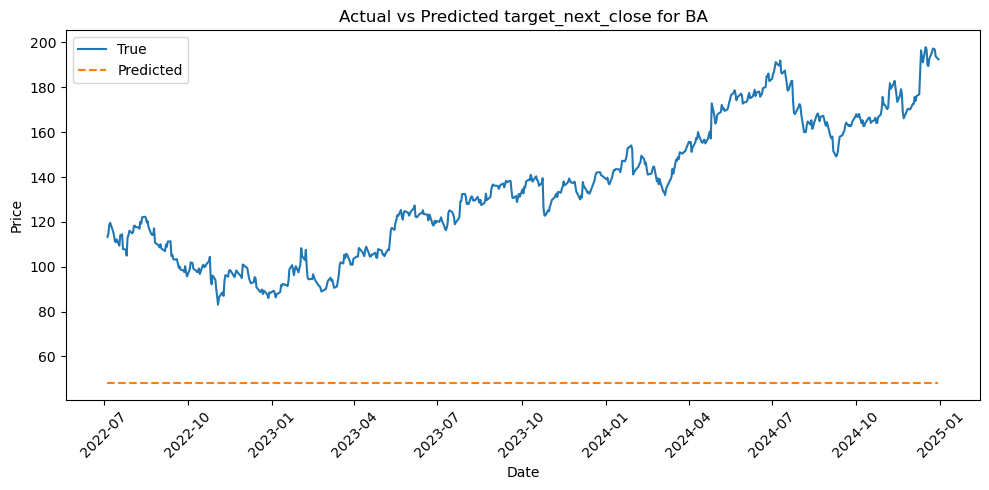

<Figure size 1000x500 with 0 Axes>

Text(0.5, 1.0, 'Actual vs Predicted target_next_close for IBM')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

(array([19174., 19266., 19358., 19448., 19539., 19631., 19723., 19814.,
        19905., 19997., 20089.]),
 [Text(19174.0, 0, '2022-07'),
  Text(19266.0, 0, '2022-10'),
  Text(19358.0, 0, '2023-01'),
  Text(19448.0, 0, '2023-04'),
  Text(19539.0, 0, '2023-07'),
  Text(19631.0, 0, '2023-10'),
  Text(19723.0, 0, '2024-01'),
  Text(19814.0, 0, '2024-04'),
  Text(19905.0, 0, '2024-07'),
  Text(19997.0, 0, '2024-10'),
  Text(20089.0, 0, '2025-01')])

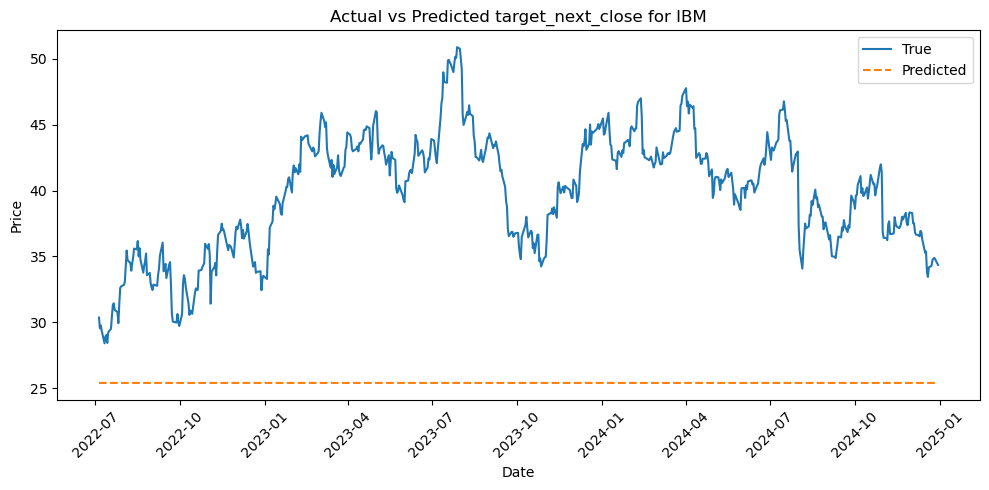

<Figure size 1000x500 with 0 Axes>

Text(0.5, 1.0, 'Actual vs Predicted target_next_close for MGM')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

(array([19174., 19266., 19358., 19448., 19539., 19631., 19723., 19814.,
        19905., 19997., 20089.]),
 [Text(19174.0, 0, '2022-07'),
  Text(19266.0, 0, '2022-10'),
  Text(19358.0, 0, '2023-01'),
  Text(19448.0, 0, '2023-04'),
  Text(19539.0, 0, '2023-07'),
  Text(19631.0, 0, '2023-10'),
  Text(19723.0, 0, '2024-01'),
  Text(19814.0, 0, '2024-04'),
  Text(19905.0, 0, '2024-07'),
  Text(19997.0, 0, '2024-10'),
  Text(20089.0, 0, '2025-01')])

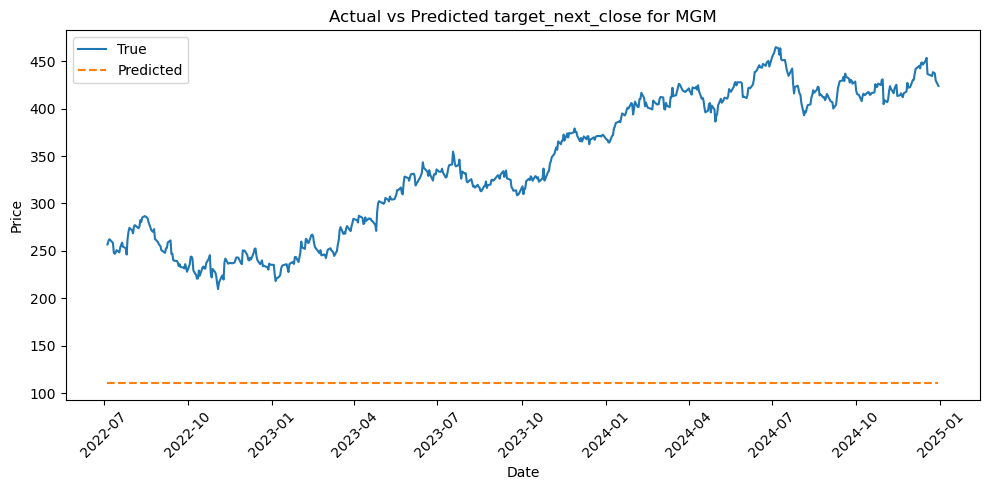

<Figure size 1000x500 with 0 Axes>

Text(0.5, 1.0, 'Actual vs Predicted target_next_close for MSFT')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

(array([19174., 19266., 19358., 19448., 19539., 19631., 19723., 19814.,
        19905., 19997., 20089.]),
 [Text(19174.0, 0, '2022-07'),
  Text(19266.0, 0, '2022-10'),
  Text(19358.0, 0, '2023-01'),
  Text(19448.0, 0, '2023-04'),
  Text(19539.0, 0, '2023-07'),
  Text(19631.0, 0, '2023-10'),
  Text(19723.0, 0, '2024-01'),
  Text(19814.0, 0, '2024-04'),
  Text(19905.0, 0, '2024-07'),
  Text(19997.0, 0, '2024-10'),
  Text(20089.0, 0, '2025-01')])

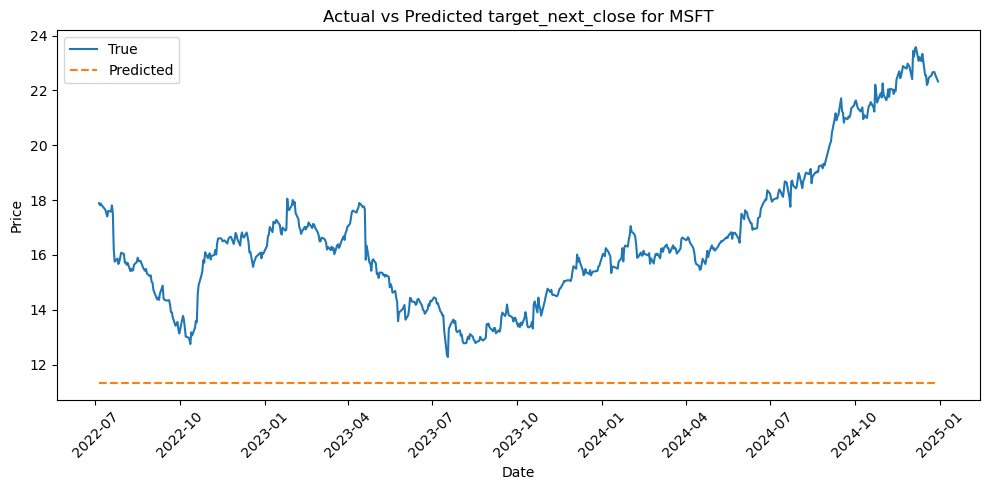

<Figure size 1000x500 with 0 Axes>

Text(0.5, 1.0, 'Actual vs Predicted target_next_close for T')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

(array([19174., 19266., 19358., 19448., 19539., 19631., 19723., 19814.,
        19905., 19997., 20089.]),
 [Text(19174.0, 0, '2022-07'),
  Text(19266.0, 0, '2022-10'),
  Text(19358.0, 0, '2023-01'),
  Text(19448.0, 0, '2023-04'),
  Text(19539.0, 0, '2023-07'),
  Text(19631.0, 0, '2023-10'),
  Text(19723.0, 0, '2024-01'),
  Text(19814.0, 0, '2024-04'),
  Text(19905.0, 0, '2024-07'),
  Text(19997.0, 0, '2024-10'),
  Text(20089.0, 0, '2025-01')])

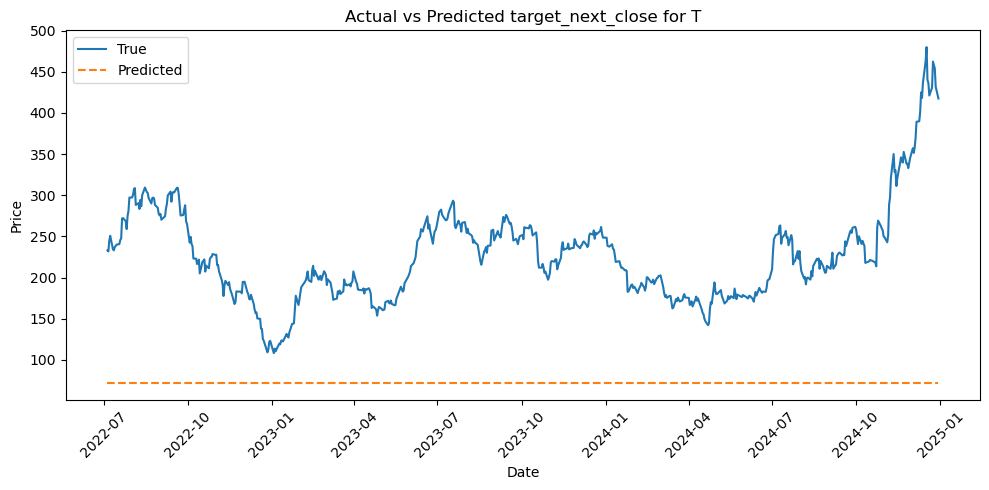

<Figure size 1000x500 with 0 Axes>

Text(0.5, 1.0, 'Actual vs Predicted target_next_close for AAPL')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

(array([19174., 19266., 19358., 19448., 19539., 19631., 19723., 19814.,
        19905., 19997., 20089.]),
 [Text(19174.0, 0, '2022-07'),
  Text(19266.0, 0, '2022-10'),
  Text(19358.0, 0, '2023-01'),
  Text(19448.0, 0, '2023-04'),
  Text(19539.0, 0, '2023-07'),
  Text(19631.0, 0, '2023-10'),
  Text(19723.0, 0, '2024-01'),
  Text(19814.0, 0, '2024-04'),
  Text(19905.0, 0, '2024-07'),
  Text(19997.0, 0, '2024-10'),
  Text(20089.0, 0, '2025-01')])

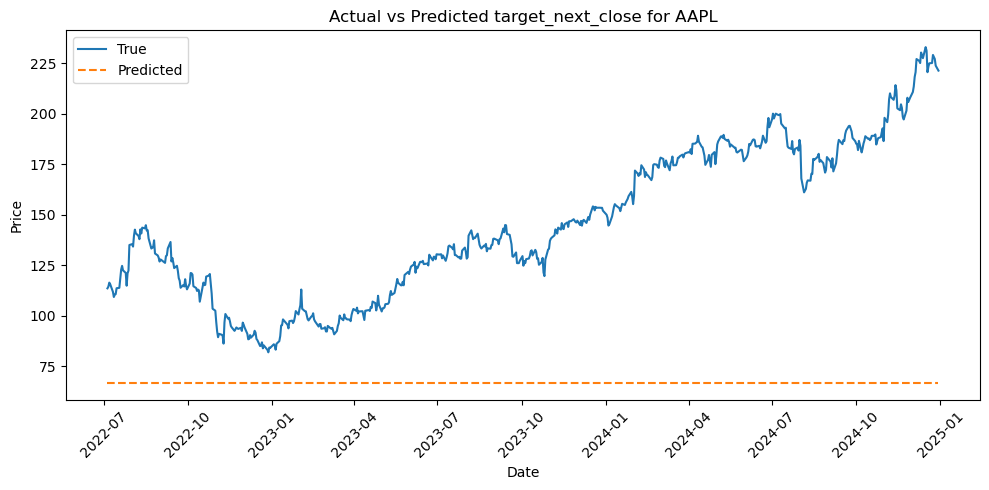

<Figure size 1000x500 with 0 Axes>

Text(0.5, 1.0, 'Actual vs Predicted target_next_close for AMZN')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

(array([19174., 19266., 19358., 19448., 19539., 19631., 19723., 19814.,
        19905., 19997., 20089.]),
 [Text(19174.0, 0, '2022-07'),
  Text(19266.0, 0, '2022-10'),
  Text(19358.0, 0, '2023-01'),
  Text(19448.0, 0, '2023-04'),
  Text(19539.0, 0, '2023-07'),
  Text(19631.0, 0, '2023-10'),
  Text(19723.0, 0, '2024-01'),
  Text(19814.0, 0, '2024-04'),
  Text(19905.0, 0, '2024-07'),
  Text(19997.0, 0, '2024-10'),
  Text(20089.0, 0, '2025-01')])

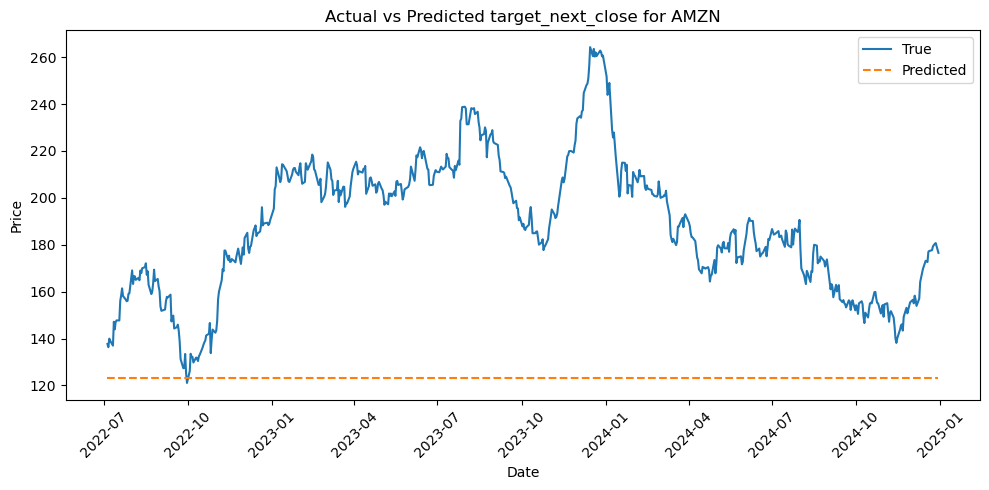

<Figure size 1000x500 with 0 Axes>

Text(0.5, 1.0, 'Actual vs Predicted target_next_close for GOOG')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

(array([19358., 19448., 19539., 19631., 19723., 19814., 19905., 19997.,
        20089.]),
 [Text(19358.0, 0, '2023-01'),
  Text(19448.0, 0, '2023-04'),
  Text(19539.0, 0, '2023-07'),
  Text(19631.0, 0, '2023-10'),
  Text(19723.0, 0, '2024-01'),
  Text(19814.0, 0, '2024-04'),
  Text(19905.0, 0, '2024-07'),
  Text(19997.0, 0, '2024-10'),
  Text(20089.0, 0, '2025-01')])

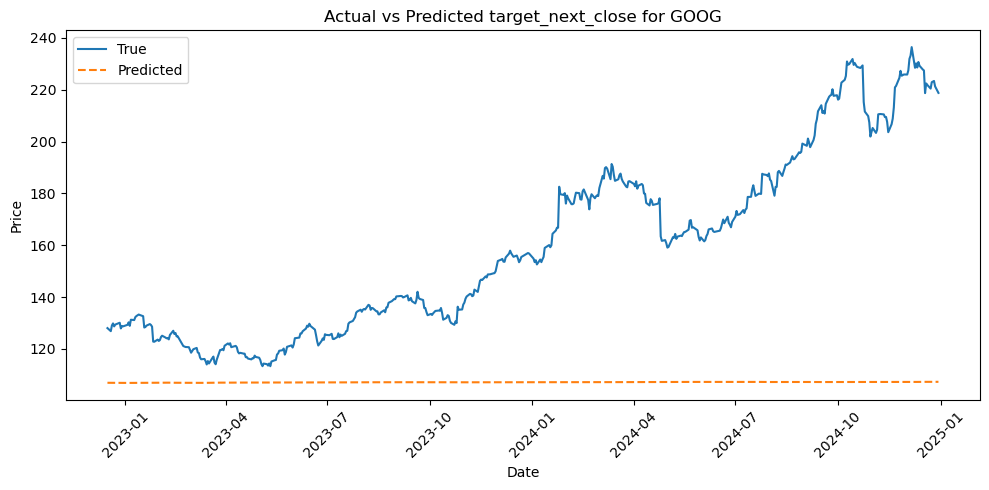

<Figure size 1000x500 with 0 Axes>

Text(0.5, 1.0, 'Actual vs Predicted target_next_close for TSLA')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

(array([19539., 19601., 19662., 19723., 19783., 19844., 19905., 19967.,
        20028., 20089.]),
 [Text(19539.0, 0, '2023-07'),
  Text(19601.0, 0, '2023-09'),
  Text(19662.0, 0, '2023-11'),
  Text(19723.0, 0, '2024-01'),
  Text(19783.0, 0, '2024-03'),
  Text(19844.0, 0, '2024-05'),
  Text(19905.0, 0, '2024-07'),
  Text(19967.0, 0, '2024-09'),
  Text(20028.0, 0, '2024-11'),
  Text(20089.0, 0, '2025-01')])

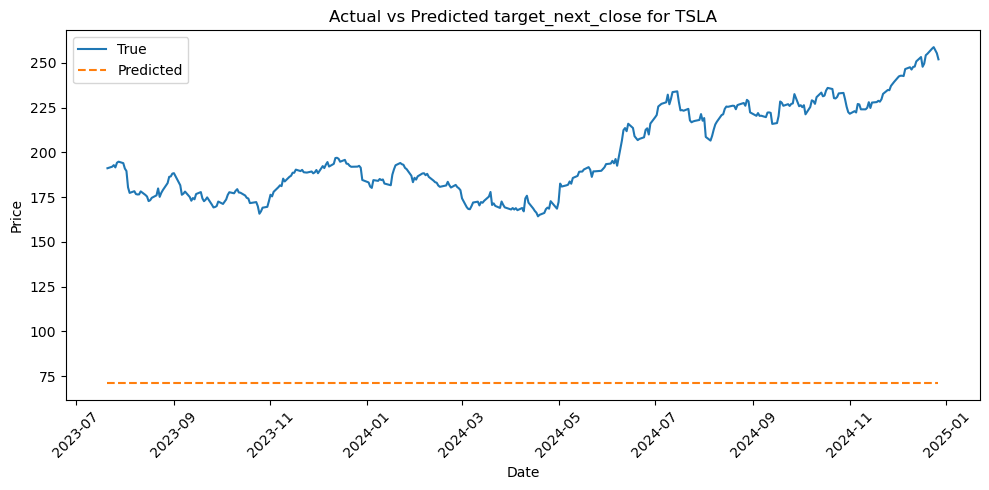

In [16]:
# Individual plots per ticker
for ticker in df_results['Ticker'].unique():
    ticker_df = df_results[df_results['Ticker'] == ticker]
    plt.figure(figsize=(10, 5))
    plt.plot(ticker_df['Date'], ticker_df['target_next_close'], label='True')
    plt.plot(ticker_df['Date'], ticker_df['pred_target_next_close'], '--', label='Predicted')
    plt.title(f"Actual vs Predicted target_next_close for {ticker}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


<Figure size 1200x600 with 0 Axes>

Text(0.5, 1.0, 'Actual vs Predicted target_next_close (Per-Ticker Fine-Tuning)')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

(array([19174., 19266., 19358., 19448., 19539., 19631., 19723., 19814.,
        19905., 19997., 20089.]),
 [Text(19174.0, 0, '2022-07'),
  Text(19266.0, 0, '2022-10'),
  Text(19358.0, 0, '2023-01'),
  Text(19448.0, 0, '2023-04'),
  Text(19539.0, 0, '2023-07'),
  Text(19631.0, 0, '2023-10'),
  Text(19723.0, 0, '2024-01'),
  Text(19814.0, 0, '2024-04'),
  Text(19905.0, 0, '2024-07'),
  Text(19997.0, 0, '2024-10'),
  Text(20089.0, 0, '2025-01')])

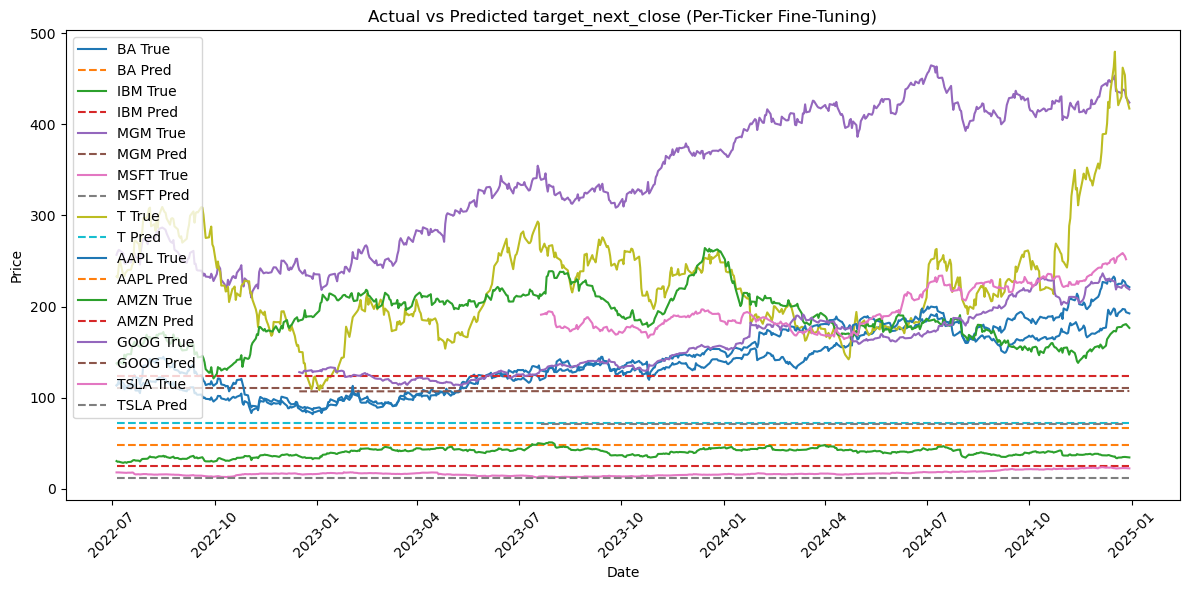

In [17]:
# Plot
plt.figure(figsize=(12, 6))
for ticker in df_results['Ticker'].unique():
    ticker_df = df_results[df_results['Ticker'] == ticker]
    plt.plot(ticker_df['Date'], ticker_df['target_next_close'], label=f'{ticker} True')
    plt.plot(ticker_df['Date'], ticker_df['pred_target_next_close'], '--', label=f'{ticker} Pred')

plt.title("Actual vs Predicted target_next_close (Per-Ticker Fine-Tuning)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()